In [122]:
!pip install wurlitzer
%load_ext wurlitzer
# Just so we can print inside a kernel

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [123]:
import numpy as np
from PIL import Image, ImageOps
from numba import cuda
import math
import timeit
import matplotlib.pyplot as plt


In [124]:
# @cuda.jit
# def noir_et_blanc(input, output):
#   x, y = cuda.grid(2)
#   if x < input.shape[0] and y < input.shape[1]:
#     R = input[x,y][0]
#     G = input[x,y][1]
#     B = input[x,y][2]
#     gris = 0.3 * R + 0.59 * G + 0.11 * B
#     output[x,y][0] = int(gris)
#     output[x,y][1] = int(gris)
#     output[x,y][2] = int(gris)

In [131]:
@cuda.jit
def gk_blur(sigma, kernel_size, kernel):
    c = kernel_size // 2
    x, y = cuda.grid(2)

    if x < kernel_size and y < kernel_size:
        exponent = -((x - c) ** 2 + (y - c) ** 2) / (2 * sigma ** 2)
        kernel[x, y] = np.int32(((1 / (2 * np.pi * sigma ** 2)) * math.exp(exponent)) * 1000)

In [127]:
@cuda.jit
def floute(input, output, kernel):
    x, y = cuda.grid(2)
    t_R, t_G, t_B = 0, 0, 0

    if x < input.shape[0] and y < input.shape[1]:
        R, G, B = input[x, y]

        centre = kernel.shape[0] // 2
        for i in range(-centre, centre + 1):
            for j in range(-centre, centre + 1):
                ni, nj = x + i, y + j
                ni_valid = 0 <= ni < input.shape[0]
                nj_valid = 0 <= nj < input.shape[1]

                pixel_value = input[ni, nj] if (ni_valid and nj_valid) else input[x, y]

                t_R += kernel[i + centre, j + centre] * pixel_value[0]
                t_G += kernel[i + centre, j + centre] * pixel_value[1]
                t_B += kernel[i + centre, j + centre] * pixel_value[2]

        output[x, y, 0] = t_R // 256
        output[x, y, 1] = t_G // 256
        output[x, y, 2] = t_B // 256

In [128]:
# def Bench(image_source):
#     image = np.asarray(image_source)
#     d_image = cuda.to_device(image)
#     d_result = cuda.device_array_like(image)
#     sigma = 11.4
#     kernel_size = 27

#     # Define thread block sizes for the benchmark
#     thread_block_sizes = [(8, 8), (16, 16), (32, 32), (64, 64)]

#     # Perform benchmark with different thread block sizes
#     for tb_size in thread_block_sizes:
#         execution_times = []

#         for _ in range(11):  # Perform at least 11 experiments, discard the first value
#             d_kernel = cuda.to_device(np.zeros((kernel_size, kernel_size), dtype=np.float32))
#             gk_blur[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

#             # Measure execution time of floute kernel
#             start_time = timeit.default_timer()
#             floute[d_image.shape, tb_size](d_image, d_result, d_kernel)
#             cuda.synchronize()
#             end_time = timeit.default_timer()

#             execution_time = end_time - start_time
#             # Calculate the grid size based on the image dimensions and thread block size
#             grid_x = math.ceil(image.shape[0] / tb[0])
#             grid_y = math.ceil(image.shape[1] / tb[1])
#             grid = (grid_x, grid_y)

#             # Call the floute kernel
#             floute[grid, tb](d_image, d_result, d_kernel)

#             # Transfer the result back to the CPU
#             result = d_result.copy_to_host()

#             # Display the original and blurred images using matplotlib
#             plt.figure()
#             plt.imshow(image)
#             plt.title("Original Image")

#             plt.figure()
#             plt.imshow(result)
#             plt.title("Blurred Image")

#             plt.show()

#             # Discard the first value (warm-up)
#             if _ > 0:
#                 execution_times.append(execution_time)

#         # Calculate and print the average execution time
#         avg_execution_time = np.mean(execution_times)
#         print(f"Thread Block Size {tb_size}: Average Execution Time: {avg_execution_time} seconds")

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

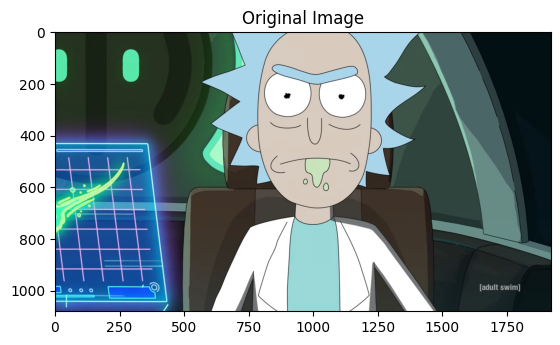

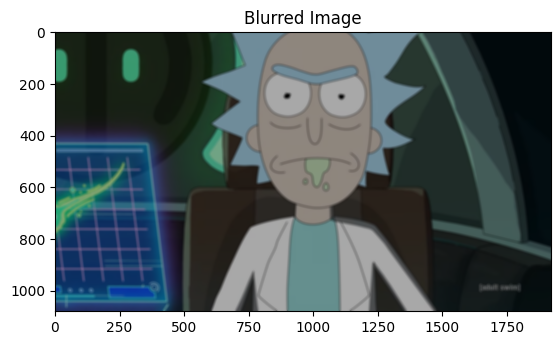

In [132]:
# Load the image
im = Image.open("test.jpg")
image = np.asarray(im)

# Define Gaussian kernel parameters
# sigma = 2.14
# kernel_size = 2*math.ceil(3*sigma)+1
sigma = 11.4
kernel_size = 27

# Create and blur the Gaussian kernel
kernel = np.zeros((kernel_size, kernel_size), np.float32)
d_kernel = cuda.to_device(kernel)
gk_blur[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

gk  = d_kernel.copy_to_host()
print(gk)

# Apply the blurred kernel to the image
d_image = cuda.to_device(image)
d_result = cuda.device_array_like(image)

# Define the thread block size
tb = (16, 16)

# Calculate the grid size based on the image dimensions and thread block size
grid_x = math.ceil(image.shape[0] / tb[0])
grid_y = math.ceil(image.shape[1] / tb[1])
grid = (grid_x, grid_y)

# Call the floute kernel
floute[grid, tb](d_image, d_result, d_kernel)

# Transfer the result back to the CPU
result = d_result.copy_to_host()

# Display the original and blurred images using matplotlib
plt.figure()
plt.imshow(image)
plt.title("Original Image")

plt.figure()
plt.imshow(result)
plt.title("Blurred Image")

plt.show()

In [130]:
#

NameError: ignored